# Part III: Post analysis (Colab)

This tutorial is a Jupyter notebook that illustrates how to load & open output files from Tapqir analysis. To work with the live version of the notebook run it in Google Colab using the link above.

## Set up the environment

* Connect Google Drive to be able to save the analysis output (to view Files & Folders click on a Folder icon on the left):

In [1]:
# Run this cell to connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")
# change directory to the tutorial folder
%cd drive/MyDrive/tutorial

Mounted at /content/drive
/content/drive/MyDrive/tutorial


* Run the cell below to install `tapqir` (takes about a minute):

In [2]:
!pip install --quiet git+https://github.com/gelles-brandeis/tapqir.git#egg=tapqir[colab] > install.log

## Data file

After processing raw input data (`tapqir glimpse` command) Tapqir stores processed data in a `data.tpqr` file.

In [3]:
# import load function that loads Tapqir data files
from tapqir.utils.dataset import load

In [4]:
# we load data from current directory ("."). Tapqir will automatically look for data.tpqr file in this directory
data = load(".")

In [5]:
data

CosmosDataset: Rpb1SNAP549
  images           tensor(N=331 on-target AOIs, Nc=526 off-target AOIs, F=790 frames, C=1 channels, P=14 pixels, P=14 pixels)
  x                tensor(N=331 on-target AOIs, Nc=526 off-target AOIs, F=790 frames, C=1 channels)
  y                tensor(N=331 on-target AOIs, Nc=526 off-target AOIs, F=790 frames, C=1 channels)

  offset.samples   tensor([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
                          104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116],
                         dtype=torch.int32)
        .weights   tensor([2.8129e-06, 6.7511e-05, 4.1210e-04, 1.7932e-03, 7.1871e-03, 2.1366e-02,
                          4.7677e-02, 9.0093e-02, 1.3192e-01, 1.6421e-01, 1.5248e-01, 1.0433e-01,
                          7.7949e-02, 5.2655e-02, 3.5667e-02, 2.2335e-02, 1.9520e-02, 1.6328e-02,
                          1.2553e-02, 8.6892e-03, 7.2546e-03, 5.8228e-03, 4.4402e-03, 3.1153e-03,
                    

Data is stored as a `CosmosDataset` object that has a title (`Rpb1SNAP549`), `images` attribute for AOI images (torch.Tensor object with `(N+Nc, F, C, P, P)` shape), `x` attribute for target locations on the _x_-axis (torch.Tensor with `(N+Nc, F, C)` shape), and `y` attribute for target locations on the _y_-axis (torch.Tensor with `(N+Nc, F, C)` shape), and `offset` attribute for camera offset data.

As an example we will plot frames 625, 628, 630, 633, 635, 638, 640, 643, 645 from AOI 163 and also show target locations (red `+` sign).

In [6]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

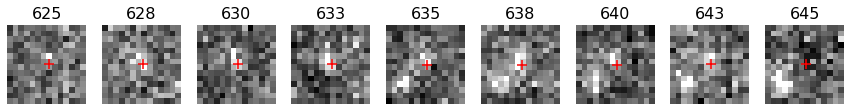

In [7]:
fig = plt.figure(figsize=(15, 1.5))
n = 163  # AOI
c = 0  # color channel
frames = [625, 628, 630, 633, 635, 638, 640, 643, 645]

for i, f in enumerate(frames):
    ax = fig.add_subplot(1, 9, i + 1)
    ax.imshow(data.images[n, f, c].numpy(), vmin=340, vmax=635, cmap="gray")
    ax.scatter(
        data.x[n, f, c].item(),
        data.y[n, f, c].item(),
        c="r",
        s=100,
        marker="+",
    )
    ax.set_title(f, fontsize=16)
    ax.axis("off")

`offset` is an `OffsetData` object that has `samples` attribute for camera offset values and `weights` attribute for their probabilities (together they define and Empirical distribution for the offset signal). Let's plot it.

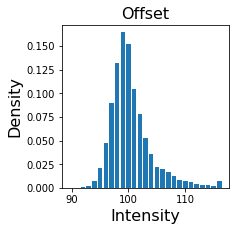

In [8]:
plt.figure(figsize=(3, 3))
plt.bar(data.offset.samples, data.offset.weights)
plt.title("Offset", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlabel("Intensity", fontsize=16)
plt.show()

## Parameters file

Model parameters with 95% CI (credible interval) are stored in `cosmos-params.tpqr` file (nested dictionary of `torch.Tensor`s). Let's load it first.

In [9]:
import torch

In [10]:
params = torch.load("cosmos-channel0-params.tpqr")

In [11]:
# list all parameters
params.keys()

dict_keys(['gain', 'proximity', 'lamda', 'pi', 'Keq', 'height', 'width', 'x', 'y', 'background', 'm_probs', 'theta_probs', 'z_probs', 'z_map'])

- `gain` - $g$ camera gain
- `proximity` - $\sigma^{xy}$ proximity
- `lamda` - $\lambda$ off-target binding rate
- `pi` - $\pi$ average on-target binding probability
- `Keq` - equilibrium constant calculated as $\frac{\pi}{1-\pi}$
- `z_probs` - $p(z=1|D)$ or $p(\mathsf{specific})$ probability of there being any target-specific spot in an AOI image
- `z_map` - most likely value (0 or 1) for target-specific spot presence (obtained from $p(\mathsf{specific})$ using 0.5 cutoff)
- `theta_probs` - $p(\theta=k|D)$ target-specific spot index probabilities
- `m_probs` - $p(m=1|D)$ spot presence probabilities
- `height` - $h$ spot intensity
- `width` - $w$ spot width
- `x` - $x$ spot position on _x_-axis
- `y` - $y$ spot position on _y_-axis
- `background` - $b$ background intensity


For example, let's look at gain $g$:

In [12]:
params["gain"]

{'LL': tensor(6.6370, dtype=torch.float64),
 'Mean': tensor(6.6390, dtype=torch.float64),
 'UL': tensor(6.6410, dtype=torch.float64)}

It is a dictionary with `Mean` (6.6390), 95% CI lower-limit `LL` (6.6370) and upper-limit `UL` (6.6410) entries.

Let's plot $p(\mathsf{specific})$ for AOI 163 and frames from 625 to 645:

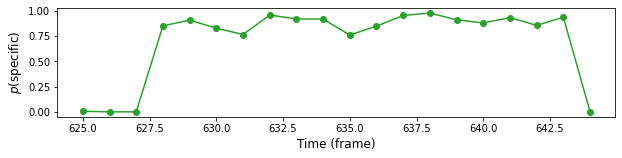

In [13]:
n = 163
f1, f2 = 625, 645

plt.figure(figsize=(10, 2))
plt.plot(torch.arange(f1, f2), params["z_probs"][n, f1:f2], "o-", color="C2")
plt.ylabel(r"$p(\mathsf{specific})$", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.show()

To plot credible intervals we can use `pyplot`'s `fill_between` method. Here is the plot of intensity $h$ for spot 1 in the same range of frames:

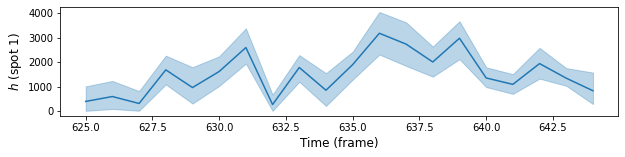

In [14]:
k = 0  # spot 1
n = 163  # AOI
f1, f2 = 625, 645  # frame range

plt.figure(figsize=(10, 2))
plt.plot(torch.arange(f1, f2), params["height"]["Mean"][k, n, f1:f2], "-", color="C0")
plt.fill_between(
    torch.arange(f1, f2),
    params["height"]["LL"][k, n, f1:f2],
    params["height"]["UL"][k, n, f1:f2],
    color="C0",
    alpha=0.3,
)
plt.ylabel(r"$h$ (spot 1)", fontsize=12)
plt.xlabel("Time (frame)", fontsize=12)
plt.show()

### Probabilistic rastergram

We can plot $p(\mathsf{specific})$ as a probabilistic rastergram.

In [15]:
import matplotlib as mpl

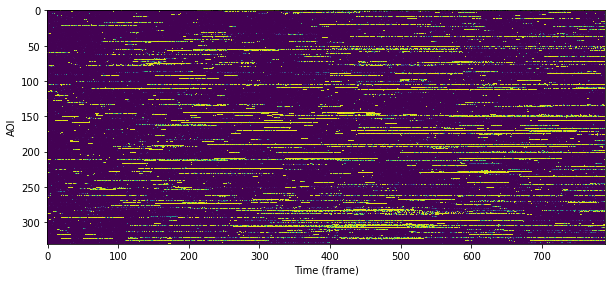

In [19]:
plt.figure(figsize=(10, 5))
plt.imshow(
    params["z_probs"][: data.N],
    norm=mpl.colors.Normalize(vmin=0, vmax=1),
    aspect="equal",
    interpolation="none",
)
plt.ylabel("AOI")
plt.xlabel("Time (frame)")
plt.show()

### Global parameters

`cosmos-channel0-summary.csv` file contains values of global parameters (for easy access). In python we can load it using `pandas` module. 

In [20]:
import pandas as pd

In [21]:
summary = pd.read_csv("cosmos-channel0-summary.csv", index_col=0)
summary

,Mean,95% LL,95% UL
gain,6.638950,6.637002,6.641002
proximity,0.587923,0.584052,0.591970
lamda,0.267904,0.266214,0.269702
pi,0.093122,0.091986,0.094290
Keq,0.102682,0.101304,0.104106
SNR,1.614429,NaN,NaN
